## Comparison of 6 different Clustering Algorithms on 3 different Datasets

### Imports

In [10]:
import time
import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets, cluster
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score

### Global variables

In [11]:
N = 3
results = {}

### Initialize the datasets

In [12]:
class Dataset(object):
    
    def __init__(self, name, dataset):
        self.name = name
        self.value = dataset

In [13]:
def populate_boston_with_labels(boston):
    old_target = boston.value["target"]
    new_target = np.int32(np.zeros(len(old_target)) - 1)

    boston_min = np.int32(np.min(old_target))
    boston_max = np.int32(np.max(old_target))
    boston_inc = np.int32((boston_max - boston_min) / N)

    for i in range(len(old_target)):
        for j in range(boston_min, boston_max, boston_inc):
            if old_target[i] >= j:
                new_target[i] += 1
            else:
                break

    boston.value["target"] = new_target % N

In [14]:
boston = Dataset("boston", datasets.load_boston())
digits3 = Dataset("digits3", datasets.load_digits(n_class=N))
iris = Dataset("iris", datasets.load_iris())

In [15]:
populate_boston_with_labels(boston)
datasets = [boston, digits3, iris]

### Initialize ClusteringAlgorithm to show the results of each clustering approach for each dataset

In [16]:
class ClusteringAlgorithm(object):
    
    def __init__(self, name, algorithm):
        self.name = name
        self.algorithm = algorithm
        self.score = 0.
        self.time = 0.
        
    @staticmethod
    def scatter(data, X):
        colors = ["green", "purple", "blue"]

        for i in range(N):
            inds = data == i
            plt.scatter(X[inds, 0], X[inds, 1], c=colors[i], marker=".")
        
    def show(self, dataset, X):
        print("Normalized mutual info score of %s: %.4f" % (dataset.name, self.score))
        plt.figure(figsize=(10, 4))
        
        # Plotting for Cluster Labels
        plt.subplot(1, 2, 1)
        plt.title("%s Cluster Labels of %s" % (self.name, dataset.name))
        plt.text(.99, .01, ('%.2fs' % self.time).lstrip('0'), 
                 transform=plt.gca().transAxes, size=15, horizontalalignment='right')
        self.scatter(self.algorithm.labels_, X)

        # Plotting for Class Labels
        plt.subplot(1, 2, 2)
        plt.title("Class Labels of %s" % dataset.name)
        self.scatter(dataset.value.target, X)
        
        plt.show()
        
    def fit(self, dataset):
        t = time.time()
        
        self.algorithm.fit(dataset.value.data)
        self.score = normalized_mutual_info_score(self.algorithm.labels_, dataset.value.target)
        
        self.time = time.time() - t
        
    def get_results(self):
        return self.score, self.time, (self.score / self.time)

### KMeans

--------------------------------------------------------------------------------
Normalized mutual info score of boston: 0.1312


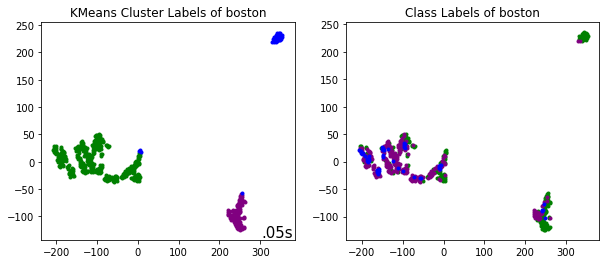

--------------------------------------------------------------------------------
Normalized mutual info score of digits3: 0.7605


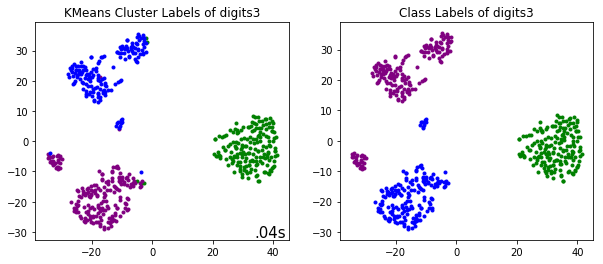

--------------------------------------------------------------------------------
Normalized mutual info score of iris: 0.7582


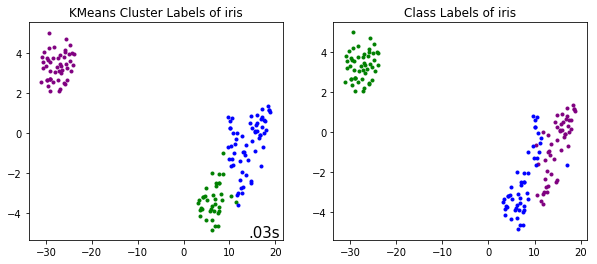

--------------------------------------------------------------------------------


In [17]:
print("--------------------------------------------------------------------------------")
tsne = TSNE(n_components=2, init="pca")
kmeans = ClusteringAlgorithm("KMeans", cluster.KMeans(n_clusters=N))

for dataset in datasets:
    X = tsne.fit_transform(dataset.value.data)
    
    kmeans.fit(dataset)
    kmeans.show(dataset, X)
    
    results[kmeans.name, dataset.name] = kmeans.get_results()
    print("--------------------------------------------------------------------------------")

### Mini-Batch KMeans

--------------------------------------------------------------------------------
Normalized mutual info score of boston: 0.1312


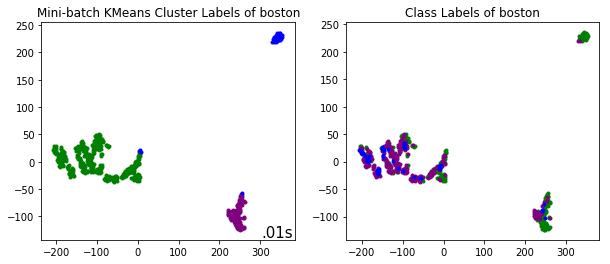

--------------------------------------------------------------------------------
Normalized mutual info score of digits3: 0.7652


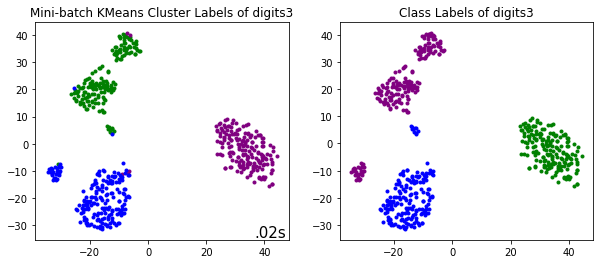

--------------------------------------------------------------------------------
Normalized mutual info score of iris: 0.7981


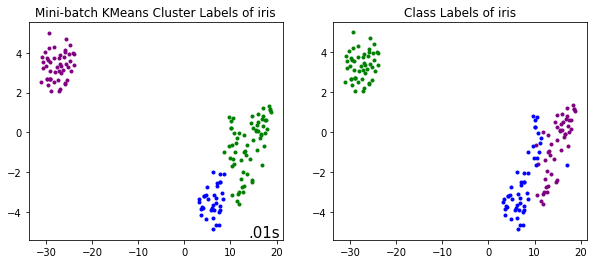

--------------------------------------------------------------------------------


In [18]:
print("--------------------------------------------------------------------------------")
tsne = TSNE(n_components=2, init="pca")
mini_batch = ClusteringAlgorithm("Mini-batch KMeans", cluster.MiniBatchKMeans(n_clusters=N))

for dataset in datasets:
    X = tsne.fit_transform(dataset.value.data)
    
    mini_batch.fit(dataset)
    mini_batch.show(dataset, X)
    
    results[mini_batch.name, dataset.name] = mini_batch.get_results()
    print("--------------------------------------------------------------------------------")

### MeanShift

--------------------------------------------------------------------------------
Normalized mutual info score of boston: 0.3539


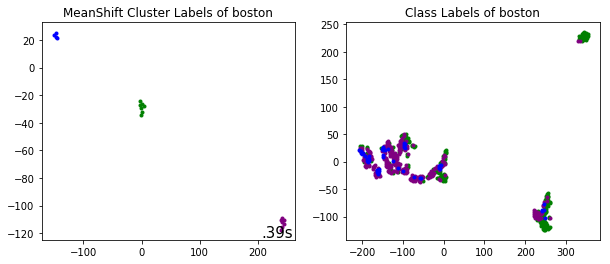

--------------------------------------------------------------------------------
Normalized mutual info score of digits3: 0.4461


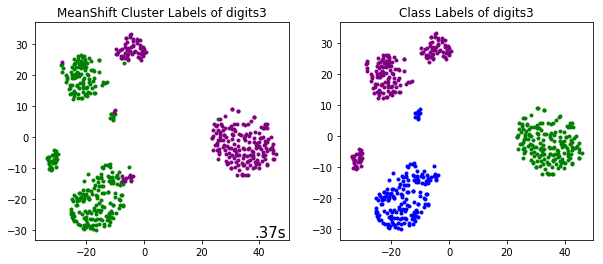

--------------------------------------------------------------------------------
Normalized mutual info score of iris: 0.7741


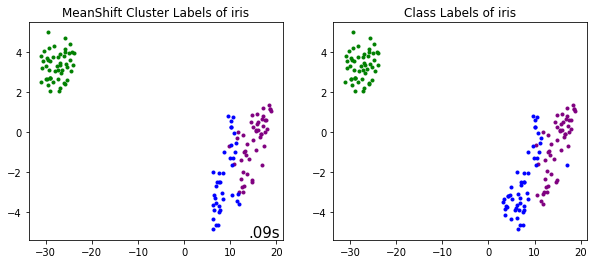

--------------------------------------------------------------------------------


In [19]:
print("--------------------------------------------------------------------------------")
tsne = TSNE(n_components=2, init="pca")

for dataset, quantile in zip(datasets, [.01, .18, .03]):
    X = tsne.fit_transform(dataset.value.data) 
    bandwidth = cluster.estimate_bandwidth(X, quantile=quantile)
    
    mean_shift = ClusteringAlgorithm("MeanShift", cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True))
    mean_shift.fit(dataset)
    mean_shift.show(dataset, X)
    
    results[mean_shift.name, dataset.name] = mean_shift.get_results()
    print("--------------------------------------------------------------------------------")

### AffinityPropagation

--------------------------------------------------------------------------------
Normalized mutual info score of boston: 0.3751


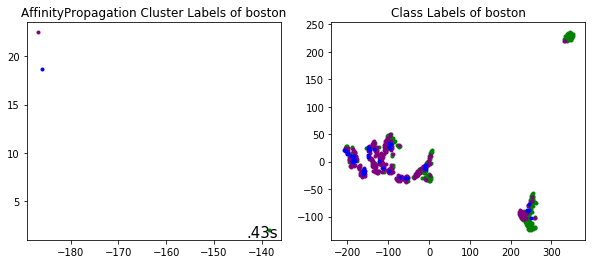

--------------------------------------------------------------------------------
Normalized mutual info score of digits3: 0.4182


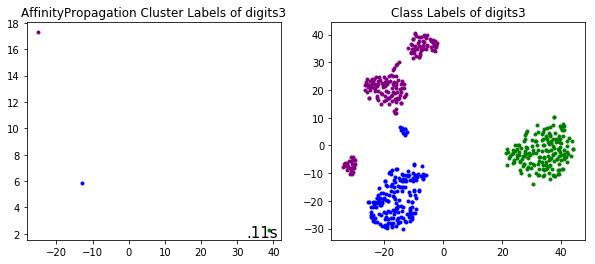

--------------------------------------------------------------------------------
Normalized mutual info score of iris: 0.7981


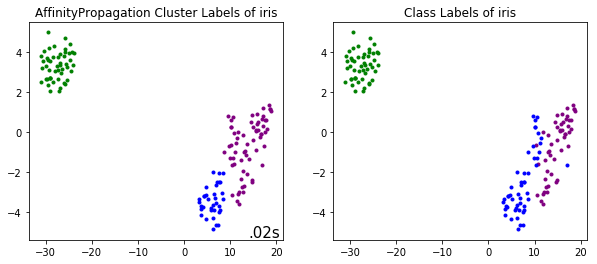

--------------------------------------------------------------------------------


In [20]:
print("--------------------------------------------------------------------------------")
tsne = TSNE(n_components=2, init="pca")

for dataset, damping in zip(datasets, [.92, .98, .6]):
    X = tsne.fit_transform(dataset.value.data)
    
    affinity_propagation = ClusteringAlgorithm(
        "AffinityPropagation", cluster.AffinityPropagation(damping=damping, preference=-40))
    affinity_propagation.fit(dataset)
    affinity_propagation.show(dataset, X)
    
    results[affinity_propagation.name, dataset.name] = affinity_propagation.get_results()
    print("--------------------------------------------------------------------------------")

### SpectralClustering

--------------------------------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Normalized mutual info score of boston: 0.1363


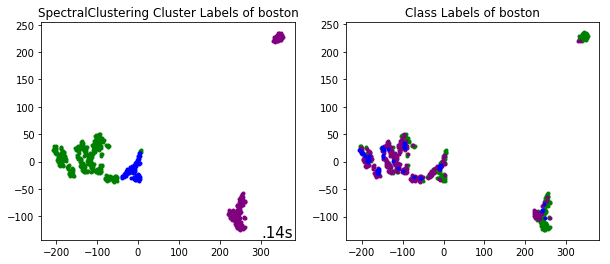

--------------------------------------------------------------------------------
Normalized mutual info score of digits3: 0.7101


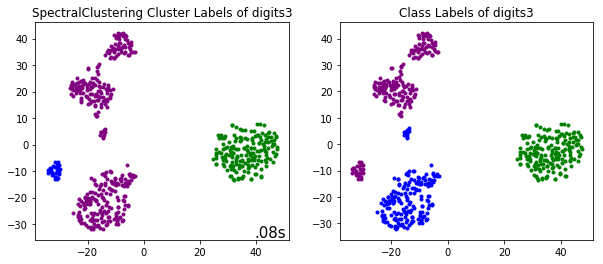

--------------------------------------------------------------------------------
Normalized mutual info score of iris: 0.8058


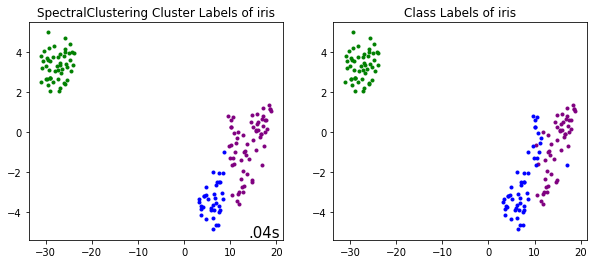

--------------------------------------------------------------------------------


In [21]:
print("--------------------------------------------------------------------------------")
tsne = TSNE(n_components=2, init="pca")  
spectral = ClusteringAlgorithm("SpectralClustering", cluster.SpectralClustering(
    n_clusters=N, affinity="nearest_neighbors", eigen_solver="arpack"))

for dataset in datasets:
    X = tsne.fit_transform(dataset.value.data)
    
    spectral.fit(dataset)
    spectral.show(dataset, X)
    
    results[spectral.name, dataset.name] = spectral.get_results()
    print("--------------------------------------------------------------------------------")

### AgglomerativeClustering 

--------------------------------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 14 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


Normalized mutual info score of boston: 0.1424


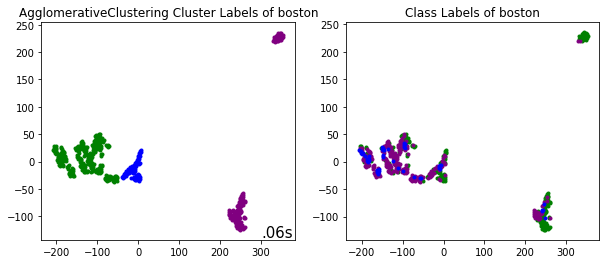

--------------------------------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 9 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


Normalized mutual info score of digits3: 0.7544


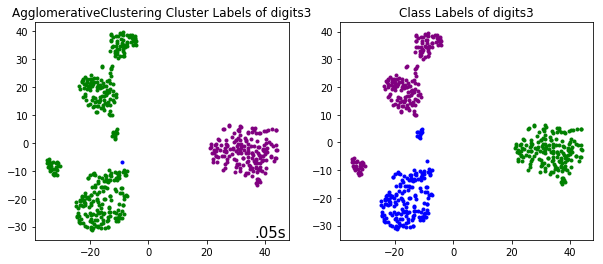

--------------------------------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


Normalized mutual info score of iris: 0.7452


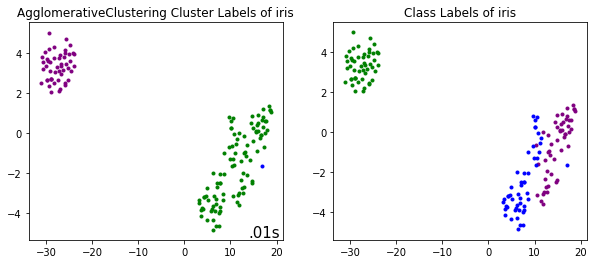

--------------------------------------------------------------------------------


In [22]:
print("--------------------------------------------------------------------------------")
tsne = TSNE(n_components=2, init="pca")

for dataset in datasets:
    X = tsne.fit_transform(dataset.value.data)
    
    connectivity = kneighbors_graph(X, n_neighbors=N, include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    agglomerative = ClusteringAlgorithm(
        "AgglomerativeClustering", cluster.AgglomerativeClustering(
            n_clusters=N, affinity="cityblock", linkage="average", connectivity=connectivity))
    agglomerative.fit(dataset)
    agglomerative.show(dataset, X)
    
    results[agglomerative.name, dataset.name] = agglomerative.get_results()
    print("--------------------------------------------------------------------------------")

### Final Results

In [23]:
def show_graph_info(graph_info, algorithm_names):
    for dataset in datasets:
        plot_data = []
        
        for algorithm_name in algorithm_names:
            plot_data.append(results[algorithm_name, dataset.name][i])

        plt.plot(plot_data, label=dataset.name)

    plt.title(graph_info)
    plt.xticks(range(len(algorithm_names)), algorithm_names, rotation='vertical')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()

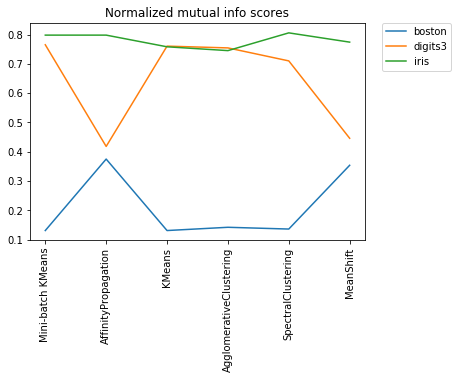

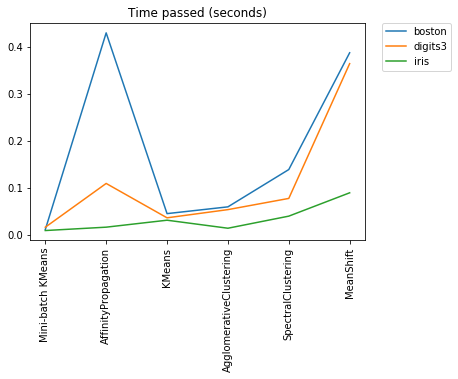

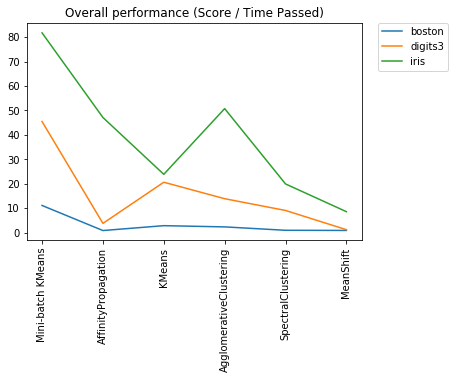

In [24]:
graph_infos = ["Normalized mutual info scores", "Time passed (seconds)", "Overall performance (Score / Time Passed)"]
algorithm_names = list(set([algorithm_name for algorithm_name, dataset_name in results]))

for i in range(len(graph_infos)):
    show_graph_info(graph_infos[i], algorithm_names)